In [ ]:
!pip install einops
!pip install torchmetrics
!pip install livelossplot
!pip install pybedtools
!pip install Bio
!pip install Sophia-Optimizer

In [ ]:
# !nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install accelerate

# Import

In [ ]:
import os

os.getpid()
from functools import partial
from scipy.stats import zscore
import torch
import copy
import itertools
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
from IPython.display import display
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import random
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.modules.activation import ReLU
from torch.optim import Adam
from tqdm import tqdm_notebook
from torchvision.utils import save_image
import matplotlib
import math
from inspect import isfunction
from functools import partial
import scipy
from scipy.special import rel_entr
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torch import nn, einsum
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.animation as animation
import matplotlib.image as mpimg
import glob
from PIL import Image
from typing import List, Union
from torchmetrics.functional import kl_divergence
import random
import gc
from livelossplot import PlotLosses
from Bio import SeqIO
import pandas as pd
import math
import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer
from memory_efficient_attention_pytorch import Attention
from accelerate import Accelerator
from typing import List, Optional
%matplotlib inline

In [ ]:
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import editdistance
%matplotlib inline
%pylab inline
import torch
import copy
import random
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
from IPython.display import display
import torch.nn as nn
from sklearn.manifold import TSNE
import os
from scipy.spatial import KDTree
import numpy as np
import pandas as pd
os.getpid()
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import seaborn as sns

from typing import Optional, Tuple

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['pylab', 'random', 'einsum', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#Params

In [ ]:
GLOBAL_SEED = 42
NUCLEOTIDES = ['A', 'C', 'T', 'G']
types = ["Z-DNA", "G-quad", "H-DNA"]
N_SAMPLES = 1000
EPOCHS = 10000
SEQ_SIZE = 50
CHANNELS = 1
LEARNING_RATE = 1e-5
TIMESTEPS = 100
RESNET_BLOCK_GROUPS = 4
BATCH_SIZE = 16
TOTAL_CLASS_NUMBER = 2
gradient_accumulation_steps = 8

https://github.com/pinellolab/DNA-Diffusion/tree/main

In [ ]:
GLOBAL_SEED = 42
# Global seed

BATCH_SIZE = 128
# Batch size

RECOVERY_THRESHOLD = 100
# number of nucleotides we need to recover to classify a motif as correctly recovered

num_training_updates = 15000
# The number of training updates to perform on the model

N_EPOCHS = 200
# The number of epochs to train the model for

num_hiddens = 128
# The number of hidden units in the model's hidden layers

num_residual_hiddens = 32
# The number of hidden units in the model's residual hidden layers

num_residual_layers = 2
# The number of residual layers in the model

embedding_dim = 64
# The dimensionality of the model's embeddings

num_embeddings = 512
# The number of embeddings in the model

commitment_cost = 0.25
# The commitment cost of the model, controlling the amount of information preserved in the latent space

decay = 0.999
# The decay rate of the model's moving average

learning_rate = 1e-3
# the learning rate of the net

NUCLEOTIDES = {"A": 0, "T": 1, "G": 2, "C": 3}
# Lookup for the nucleotides

NUCLEOTIDES_REVERSED = {0: "A", 1: "T", 2: "G", 3: "C"}
# Reversed lookup dict is needed when reversing the one-hot encoding for the metric 6

In [ ]:
codes = {
 'A': [1., 0., 0., 0., 0.],
 'T': [0., 1., 0., 0., 0.],
 'G': [0., 0., 1., 0., 0.],
 'C': [0., 0., 0., 1., 0.],
 'N': [0., 0., 0., 0., 1.],
 }

#Functions

In [ ]:
def seed_everything(seed=GLOBAL_SEED):
    """ "
    Seed everything.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def one_hot_encode_sequences(seq: str, include_n: Optional[bool] = False) -> torch.Tensor:
    """
    Converts a sequence of nucleotides to a one-hot encoded tensor.

    Args:
        seq (str): The sequence of nucleotides to encode.
        include_n (bool, optional): Whether to include 'N' nucleotides in the encoding.

    Returns:
        torch.Tensor: The one-hot encoded tensor, with shape (sequence_length, 4).
    """
    num_seq = []
    for nucleotide in seq:
        num_seq.append(NUCLEOTIDES[nucleotide])
    return (F.one_hot(torch.tensor(num_seq).to(torch.int64), num_classes=len(NUCLEOTIDES))).T

In [ ]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [ ]:
def KL_divergence(real: pd.Series, generated: pd.Series) -> torch.Tensor:
    """
    This function encapsulates the logic of evaluating the KL divergence metric
    between two sequences.
    Returns
    -------
    kl_divergence: Float
      The KL divergence between the input and output (generated)
      sequences' distribution
    """

    kl_pq = rel_entr(real, generated)
    return np.sum(kl_pq)

In [ ]:
def diversity(
    generated, real, scoring_metric=KL_divergence, plot_motif_probs=False
):
    """
    This function encapsulates the logic of evaluating the difference between the distribution
    of frequencies between generated (diffusion/df_motifs_a) and the input (training/df_motifs_b) for an arbitrary metric ("motif_scoring_metric")

    Please note that some metrics, like KL_divergence, are not metrics in official sense. Reason
    for that is that they dont satisfy certain properties, such as in KL case, the simmetry property.
    Hence it makes a big difference what are the positions of input.
    """
    set_all_data = set(generated.index.values.tolist() + real.index.values.tolist())
    create_new_matrix = []
    for x in set_all_data:
        list_in = []
        list_in.append(x)  # adding the name
        if x in generated.index:
            list_in.append(generated.loc[x][0])
        else:
            list_in.append(1)

        if x in real.index:
            list_in.append(real.loc[x][0])
        else:
            list_in.append(1)

        create_new_matrix.append(list_in)

    df_kl = pd.DataFrame(create_new_matrix, columns=['Flipon', 'generated', 'real'])

    df_kl['Generated_seqs'] = df_kl['generated'] / df_kl['generated'].sum()
    df_kl['Training_seqs'] = df_kl['real'] / df_kl['real'].sum()
    plt.rcParams["figure.figsize"] = (3, 3)
    sns.regplot(x='Generated_seqs', y='Training_seqs', data=df_kl)
    plt.xlabel('Generated_seqs')
    plt.ylabel('Training Seqs')
    plt.title('Motifs Probs')
    plt.show()

    return scoring_metric(df_kl['Genereated_seqs'].values, df_kl['Training_seqs'].values)

In [ ]:
def one_hot_encoding(sequence, target_length):
    """Convert DNA sequence to one-hot encoding."""
    nucleotides = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot_seq = np.zeros((target_length, len(nucleotides)))

    for i, nucleotide in enumerate(sequence[:target_length]):
        if nucleotide in nucleotides:
            one_hot_seq[i, nucleotides[nucleotide]] = 1

    # Flatten the one-hot encoding to a 1D vector
    one_hot_flat = one_hot_seq.flatten()

    return one_hot_flat

def preprocess_sequences(sequences, target_length):
    """Pad or truncate sequences to the target length."""
    return [seq.ljust(target_length, 'N')[:target_length] for seq in sequences]

def calculate_diversity_optimized_one_hot(dataset, target_length):
    """Calculate diversity within a single dataset using KDTree and one-hot encoding."""
    diversity = 0.0
    total_pairs = 0

    sequences = preprocess_sequences(dataset, target_length)

    sequences_one_hot = [one_hot_encoding(seq, target_length) for seq in sequences]

    kdtree = KDTree(sequences_one_hot)

    for i, seq_i in enumerate(sequences_one_hot):
        for j, seq_j in enumerate(sequences_one_hot):
            if i != j:

                edit_dist_ij = editdistance.eval(seq_i, seq_j)
                diversity += edit_dist_ij
                total_pairs += 1

    if total_pairs > 0:
        diversity /= total_pairs

    return diversity


In [ ]:
def one_hot_encoding(sequence, target_length):
    """Convert DNA sequence to one-hot encoding."""
    nucleotides = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot_seq = np.zeros((target_length, len(nucleotides)))

    for i, nucleotide in enumerate(sequence[:target_length]):
        if nucleotide in nucleotides:
            one_hot_seq[i, nucleotides[nucleotide]] = 1

    # Flatten the one-hot encoding to a 1D vector
    one_hot_flat = one_hot_seq.flatten()

    return one_hot_flat

def preprocess_sequences(sequences, target_length):
    """Pad or truncate sequences to the target length."""
    return [seq.ljust(target_length, 'N')[:target_length] for seq in sequences]

def calculate_novelty_optimized_one_hot(generated_sequences, initial_sequences, target_length):
    """Calculate novelty of the generated sequences using KDTree and one-hot encoding."""
    novelty = 0.0
    total_pairs = 0

    initial_sequences = preprocess_sequences(initial_sequences, target_length)
    generated_sequences = preprocess_sequences(generated_sequences, target_length)

    initial_sequences_one_hot = [one_hot_encoding(seq, target_length) for seq in initial_sequences]
    generated_sequences_one_hot = [one_hot_encoding(seq, target_length) for seq in generated_sequences]

    kdtree = KDTree(initial_sequences_one_hot)

    for gen_seq_one_hot in generated_sequences_one_hot:

        distance, _ = kdtree.query(gen_seq_one_hot)
        novelty += distance
        total_pairs += 1

    if total_pairs > 0:
        novelty /= total_pairs

    return novelty

# Data import and preperation

#from dataprep

In [ ]:
!mkdir numpy_arrays_data

mkdir: cannot create directory ‘numpy_arrays_data’: File exists


In [ ]:
class DataPrep:
    def __init__(self, bed_file, fasta_file):
        self.bed_file = bed_file
        self.fasta_file = fasta_file

    def process_file(self, bed_file, fasta_file):
        # Existing code for processing a single file
        pos_df = pd.read_csv(f'{bed_file}.bed', sep='\t', comment='t', header=None)
        header = ['chrom', 'chromStart', 'chromEnd']
        pos_df.columns = header[:len(pos_df.columns)]
        pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
        plt.figure(figsize=(16,8))
        plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
        pos_df.len.quantile(0.5)
        pos_df.len[pos_df.len > 512].count()
        pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
        quad_len = 512
        pos_df_filter = pos_df[pos_df.len
        <= quad_len].copy().reset_index(drop=True)
        pos_df_filter.len.max()
        pos_df_filter['add_len'] = quad_len - pos_df_filter.len
        pos_df_filter['left_add_len'] = (pos_df_filter.add_len
        / 2).astype('int64')
        pos_df_filter['right_add_len'] = pos_df_filter.add_len \
        - pos_df_filter.left_add_len
        pos_df_filter['new_chromStart'] = pos_df_filter.chromStart.astype('int64') \
        - pos_df_filter.left_add_len.astype('int64')
        pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd.astype('int64') \
        + pos_df_filter.right_add_len.astype('int64')
        pos_df_filter['new_len'] = pos_df_filter.new_chromEnd.astype('int64') \
        - pos_df_filter.new_chromStart.astype('int64')


        # Example: Save processed data to a new file
        pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd']].to_csv(
            f'{bed_file}_filter_norm_to_512.bed', sep='\t', header=None, index=None
        )
        pos_df_filter[['chrom', 'chromStart', 'chromEnd']].to_csv(
            f'{bed_file}_filter_512.bed', sep='\t', header=None, index=None
        )
        pos_df_filter.to_csv(f'{bed_file}_positions.csv')

        # Example: Process sequences and save as numpy array
        one_hot_quads = []
        line_num = 0
        with open(f'{fasta_file}_filter-norm_to_512.fasta', 'r') as f:
            for line in f:
                if line[0] != '>' and len(line) == quad_len + 1:
                    one_hot = []
                    for s in line.upper():
                        if s != '\n':
                            one_hot.append(codes[s])
                    one_hot_quads.append(one_hot)
                    line_num += 1
        one_hot_quads_np = np.array(one_hot_quads)
        np.save(f'{fasta_file}_norm_quad_labeled.npy', one_hot_quads_np)

        # Normalisation + labeling (example)
        one_hot_quads = []
        line_num = 0
        with open(f'{fasta_file}_filter-norm_to_512.fasta', 'r') as f:
            for line in f:
                if line[0] != '>' and len(line) == quad_len + 1:
                    left = pos_df_filter.iloc[line_num].left_add_len
                    right = left + pos_df_filter.iloc[line_num].len
                    one_hot = []
                    for (i, s) in enumerate(line.upper()):
                        pos = 0.
                        if left <= i and i < right:
                            pos = 1.
                        if s != '\n':
                            one_hot.append(codes[s] + [pos])
                    one_hot_quads.append(np.array(one_hot))
                    line_num += 1
        one_hot_quads_np = np.array(one_hot_quads)
        np.save(f'{fasta_file}_norm_quad_labeled.npy', one_hot_quads_np)

    def process_all_files(self):
        for file1, file2 in zip(self.bed_file, self.fasta_file):
            self.process_file(file1, file2)

In [ ]:
beds_to_process = ['/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/WuKou16',
                   '/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/zdna2016'
                    ]
fastas_to_process = ['/content/drive/My Drive/data_for_gans/preprocessed_fastas/WuKou2016',
                     '/content/drive/My Drive/data_for_gans/preprocessed_fastas/zdna2016'
                    ]

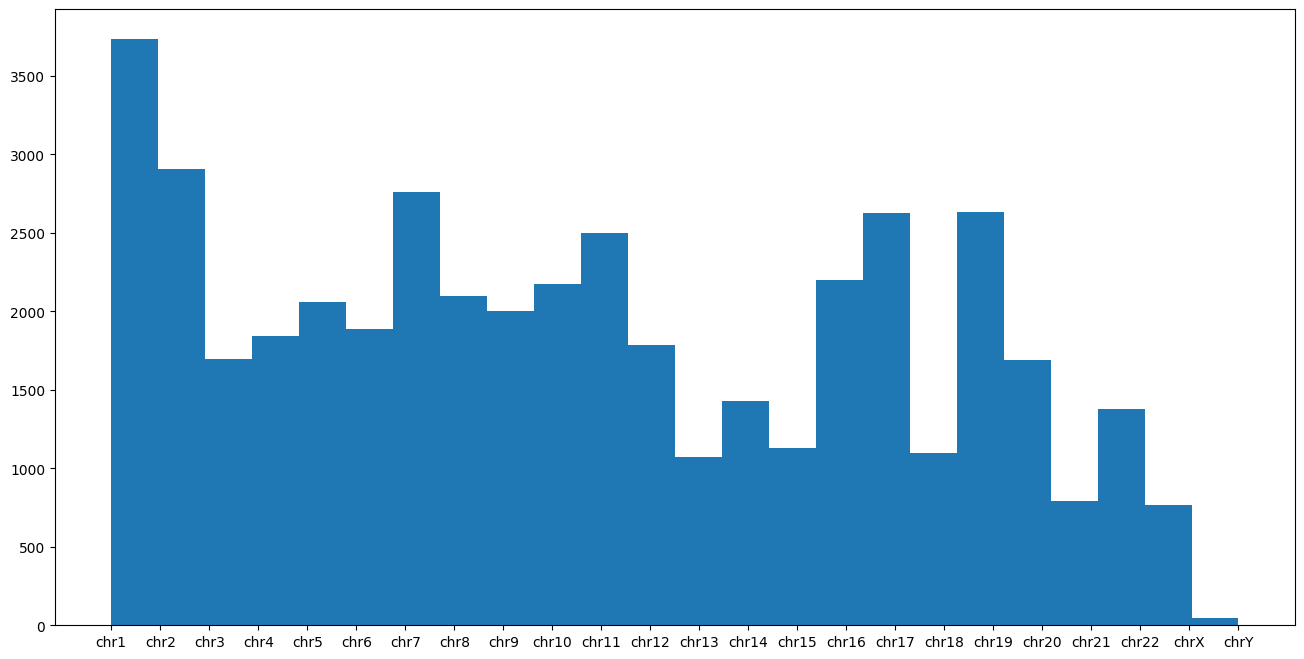

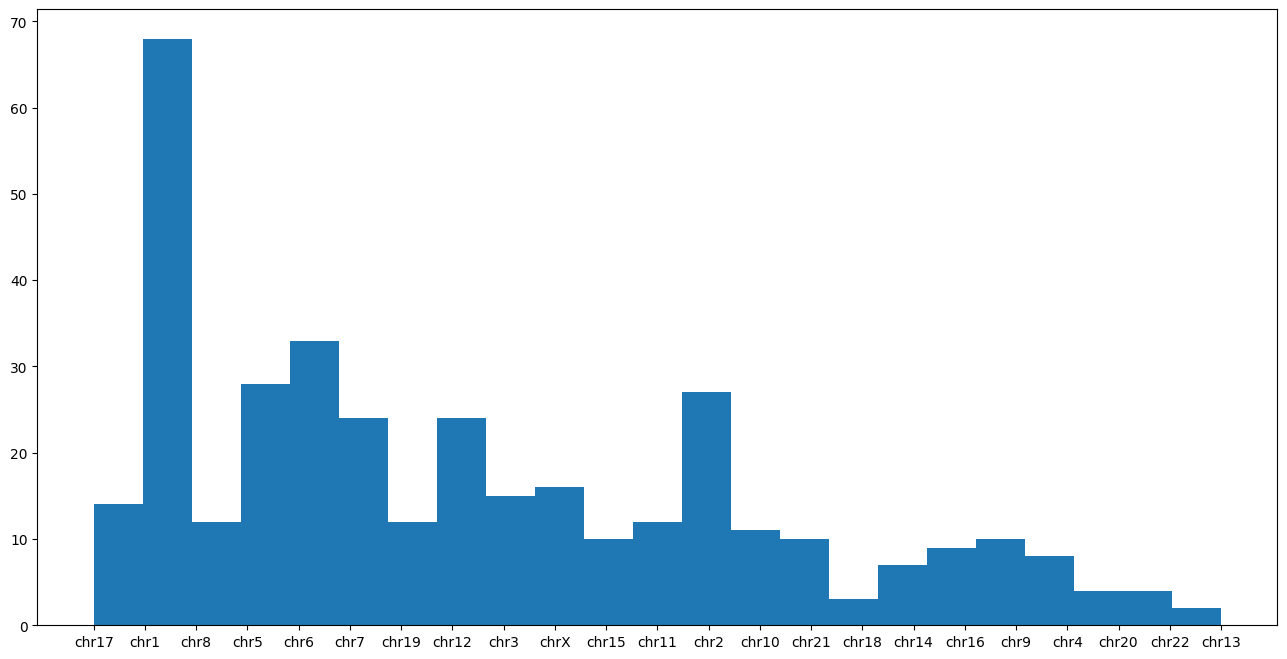

In [ ]:
data_preprocessor = DataPrep(beds_to_process, fastas_to_process)
data_preprocessor.process_all_files()

# CL

In [ ]:
sequences = []
ss_type = []
chromosomes = []
fasta_files = [
    '/content/drive/My Drive/data_for_gans/preprocessed_fastas/WuKou2016_filter-norm_to_512.fasta',
    '/content/drive/My Drive/data_for_gans/preprocessed_fastas/zdna2016_filter-norm_to_512.fasta'
]
for fasta_file in fasta_files:
  for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append(str(record.seq).upper())
    sequence = str(record.seq).upper()
    chrom_info = record.id.split('_')[0]
    chromosome = chrom_info if chrom_info.startswith("chr") else "chr" + chrom_info
    chromosomes.append(chromosome)

for seq in sequences:
    ss_type.append(types[0])
raw_dataset = pd.DataFrame({"chromosome": chromosomes, "raw_sequence": sequences, "type": ss_type, "label": 0})
raw_dataset.head()

,chromosome,raw_sequence,type,label
0,chr1:845296-845808,GCTATCTTCCAGGCCGGGAGGAAGGACCGAGGGTGGGCCCGGCGCG...,Z-DNA,0
1,chr1:845379-845891,CTGGTCCTGGCGCTGGGACCCGCAGCTGCGCCCTCTGCCTGAGCAG...,Z-DNA,0
2,chr1:845802-846314,CAGTCACCGGGGGCGGGGAGACTGGTCGACCACCCCTGAGGGCCCG...,Z-DNA,0
3,chr1:845896-846408,TCCTGGTTGAGCAGCTAGGGGGGTGTCTGGTAACCAGCCGGGCCCC...,Z-DNA,0
4,chr1:848188-848700,GCACTCCACAGCAGGAAGAAGGGCAGTGTGAACTGCTCACCACTGT...,Z-DNA,0


In [ ]:
sequences = []
ss_type = []
chromosomes = []
fasta_files = [
    '/content/drive/My Drive/data_for_gans/G4_Chip_seq_quadruplex_norm_to_500.fa'
]
for fasta_file in fasta_files:
  for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append(str(record.seq).upper())
    sequence = str(record.seq).upper()
    chrom_info = record.id.split('_')[0]
    chromosome = chrom_info if chrom_info.startswith("chr") else "chr" + chrom_info
    chromosomes.append(chromosome)

for seq in sequences:
    ss_type.append(types[1])
g_dataset = pd.DataFrame({"chromosome": chromosomes, "raw_sequence": sequences, "type": ss_type, "label": 0})
g_dataset.head()

,chromosome,raw_sequence,type,label
0,chr1:713888-714400,CCCTTCTTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCACTC...,G-quad,0
1,chr1:762660-763172,GACGGAACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCT...,G-quad,0
2,chr1:839885-840397,CTCCGAACGTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAAC...,G-quad,0
3,chr1:894460-894972,CCTGCGGGTCACGCAGGAGTCACAGCTGCCCGCACGCCCAGCTCGC...,G-quad,0
4,chr1:935301-935813,GCGCTCCTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGTGTCTGC...,G-quad,0


In [ ]:
sequences = []
ss_type = []
chromosomes = []
fasta_files = [
    "/content/drive/My Drive/data_for_gans/preprocessed_fastas/HDNA_filter-norm_to_500.fasta"
]
for fasta_file in fasta_files:
  for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append(str(record.seq).upper())
    sequence = str(record.seq).upper()
    chrom_info = record.id.split('_')[0]
    chromosome = chrom_info if chrom_info.startswith("chr") else "chr" + chrom_info
    chromosomes.append(chromosome)

for seq in sequences:
    ss_type.append(types[2])
h_dataset = pd.DataFrame({"chromosome": chromosomes, "raw_sequence": sequences, "type": ss_type, "label": 1})
h_dataset.head()

,chromosome,raw_sequence,type,label
0,chr1:30624-31136,GCCACTGTCTCGCTGGCTGCAGCGTGTGGTCCCCTTACCAGAGGTA...,H-DNA,1
1,chr1:30686-31198,CCACTCATGTTGTAGACAGAATGTTTATGTCCTCTCCAAATGCTTA...,H-DNA,1
2,chr1:31470-31982,ACTTTGGTAGGCTGACGCGAGAGGACTGCTTGAGCCCAAGAGTTTG...,H-DNA,1
3,chr1:33275-33787,AAGGGGAGGGGAGAATGGGAAGTGGCTGCTTCATGGGTACAAGGTT...,H-DNA,1
4,chr1:40392-40904,CACGCTGGCCCTCTGCTGTTCTTCGAAGCCACCAGGGCTGCATTGG...,H-DNA,1


In [ ]:
print(raw_dataset.shape)
print(g_dataset.shape)
print(h_dataset.shape)

(44661, 4)
(8723, 4)
(704830, 4)


In [ ]:
raw_dataset = pd.concat([raw_dataset, g_dataset]).sample(frac=1).reset_index(drop=True)

In [ ]:
raw_dataset = pd.concat([raw_dataset, h_dataset]).sample(frac=1).reset_index(drop=True)

In [ ]:
raw_dataset.to_csv("/content/drive/My Drive/Zdna.csv", index=False)

In [ ]:
val_chromosomes = ['chr3', 'chr8', 'chr15', 'chr17', 'chr20', 'chrX']

raw_dataset['short_chrom'] = raw_dataset['chromosome'].apply(lambda x: x.split(':')[0])

val_set = raw_dataset[raw_dataset['short_chrom'].isin(val_chromosomes)]
train_set = raw_dataset[~raw_dataset['short_chrom'].isin(val_chromosomes)]

val_set = val_set.drop(columns=['short_chrom'])
train_set = train_set.drop(columns=['short_chrom'])

In [ ]:
train_set.shape

(571008, 4)

In [ ]:
raw_dataset.raw_sequence

0         AATGAATGCATCTCCAAGGTCCACTGCAACTCAGTGATTCTGTGCA...
1         GAGGCCAAGGCAGGTGGATCACCTGAGGTCAGGAGTTTGAGACCAG...
2         AAGGGTCCGGAATGTGGAGCCTCCGCCCTGCCCCCGCCGCACCTCT...
3         TGGTTTATGATTCTTTTGCCTTGCTTGGGTAGCCAGAAATAGAATA...
4         ACTGCAGGCCTGTGATTATGAAATAGAAATAAAGCAAAATTCCCCA...
                                ...                        
758209    CAAGGGAGAAGAGTTGCAGAGACTGTTACAGTTGGTGGTGGAGAAA...
758210    CTTTCACTATCTATGGGAATATTATTTTGCTTTTTATTCCCTTTTT...
758211    AAGGAAGATATTAAAACGTTTAGTGAGATGGACATTTTGGAATTAA...
758212    CCTGCCGCATCCACCCCTGACCCTTCCAGCAGCCACAGGAGGTCAG...
758213    AACTGTTATTTTGAATTCTTGGTCAAAAAGTTTACAAATTGCCCTC...
Name: raw_sequence, Length: 758214, dtype: object

In [ ]:
raw_dataset.type

0          H-DNA
1          H-DNA
2         G-quad
3          H-DNA
4          H-DNA
           ...  
758209     H-DNA
758210     H-DNA
758211     H-DNA
758212     H-DNA
758213     H-DNA
Name: type, Length: 758214, dtype: object

In [ ]:
bedWK_df = pd.read_csv('/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/WuKou16_filter_norm_to_512.bed', sep='\t', comment='t', header=None)
bed16_df = pd.read_csv('/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/zdna2016_filter_norm_to_512.bed', sep='\t', comment='t', header=None)
bedG_df = pd.read_csv('/content/drive/My Drive/data_for_gans/G4_Chip_seq_filter_norm_to_500.bed', sep='\t', comment='t', header=None)
bedH_df = pd.read_csv('/content/drive/My Drive/data_for_gans/H-DNA.bed', sep='\t', comment='t', header=None)

In [ ]:
un_bed_dataset = pd.concat([bedWK_df, bed16_df]).reset_index(drop=True)
un_bed_dataset = pd.concat([un_bed_dataset, bedG_df]).reset_index(drop=True)
un_bed_dataset = pd.concat([un_bed_dataset, bedH_df]).reset_index(drop=True)

In [ ]:
un_bed_dataset.columns = ['chrom', 'chromStart', 'chromEnd']

In [ ]:
un_bed_dataset

,chrom,chromStart,chromEnd
0,chr1,845296,845808
1,chr1,845379,845891
2,chr1,845802,846314
3,chr1,845896,846408
4,chr1,848188,848700
...,...,...,...
758210,chrY,59327304,59327324
758211,chrY,59329449,59329467
758212,chrY,59347150,59347170
758213,chrY,59348532,59348554


# DF

In [ ]:
raw_dataset = pd.read_csv("/content/drive/My Drive/Zdna.csv")

In [ ]:
raw_dataset.head()

,chromosome,raw_sequence,type,label
0,chr12:4693472-4693984,AATGAATGCATCTCCAAGGTCCACTGCAACTCAGTGATTCTGTGCA...,H-DNA,1
1,chr6:97744700-97745212,GAGGCCAAGGCAGGTGGATCACCTGAGGTCAGGAGTTTGAGACCAG...,H-DNA,1
2,chr19:41109756-41110268,AAGGGTCCGGAATGTGGAGCCTCCGCCCTGCCCCCGCCGCACCTCT...,G-quad,0
3,chr2:29356971-29357483,TGGTTTATGATTCTTTTGCCTTGCTTGGGTAGCCAGAAATAGAATA...,H-DNA,1
4,chr7:39330368-39330880,ACTGCAGGCCTGTGATTATGAAATAGAAATAAAGCAAAATTCCCCA...,H-DNA,1


In [ ]:
class VAEDataset(Dataset):
    """
    PeaksDataset is a PyTorch dataset for representing sequences of nucleotides. It takes a DataFrame
    as input, one-hot encodes the raw sequences, and accumulates them into a list of tensors.

    Args:
        df (pandas.DataFrame): The DataFrame containing the raw sequences.

    Inputs:
        - idx (int): The index of the sequence to return.

    Outputs:
        - x (torch.Tensor): The one-hot encoded sequence, with shape (1, sequence_length, 4).
        - y (int): The target label, which is always set to 1 in this dataset.
    """

    def __init__(self, df: pd.DataFrame):
        self.sequences = []
        for curr_seq in df["raw_sequence"].tolist():
            if len(curr_seq) != 100:
                mid_index = len(curr_seq) // 2
                curr_seq = curr_seq[mid_index - 50 : mid_index + 50]
            if 'N' not in curr_seq:
                one_hot_representation = one_hot_encode_sequences(curr_seq)
                if one_hot_representation is not None:
                    one_hot_representation = one_hot_representation[None, :, :]
                    self.sequences.append(one_hot_representation)

    def __len__(self) -> int:
        return len(self.sequences)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, int]:
        return self.sequences[idx], 1

In [ ]:
train_data = VAEDataset(train_set)
train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_data = VAEDataset(val_set)
val_dl = DataLoader(val_data, batch_size=BATCH_SIZE)

In [ ]:
for batch in train_dl:
  print(batch[0].shape)

torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([128, 1, 4, 100])
torch.Size([12

In [ ]:
full_data = VAEDataset(raw_dataset)
full_dl = DataLoader(full_data, batch_size=BATCH_SIZE)

# VQ-VAE

In [ ]:
class VectorQuantizer(nn.Module):
    """
    An implementation of a vector quantizer, as described in 'Neural Discrete Representation Learning'
    (https://arxiv.org/abs/1711.00937) by van den Oord et al.

    This module can be used as a layer in a neural network to quantize the activations of the previous
    layer. During training, the quantization loss is backpropagated through this module, and the
    quantization vectors are learned.

    Args:
        num_embeddings (int): The number of quantization vectors, i.e. the number of possible values
            that each activation can take.
        embedding_dim (int): The length of each quantization vector. This should match the number of
            channels of the activations that will be quantized.
        commitment_cost (float): The weighting factor that determines the trade-off between the
            quantization loss and the commitment loss. Larger values means that the quantization vectors
            will be pushed closer to their "optimal" values, but at the expense of a higher quantization
            loss.

    Inputs:
        - inputs (torch.Tensor): The activations to be quantized, with shape (batch_size, channels,
            height, width).

    Outputs:
        - loss (torch.Tensor): The quantization loss, a scalar value.
        - quantized (torch.Tensor): The quantized activations, with the same shape as the inputs.
        - perplexity (torch.Tensor): The perplexity of the encodings, a scalar value.
        - encodings (torch.Tensor): The encodings for the inputs, with shape (batch_size,
            num_embeddings).
        - encoding_indices (torch.Tensor): The indices of the encodings in the quantization vector
            space, with shape (batch_size, 1).
    """

    def __init__(self, num_embeddings: int, embedding_dim: int, commitment_cost: float) -> None:
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1 / self._num_embeddings, 1 / self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor]:
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (
            torch.sum(flat_input**2, dim=1, keepdim=True)
            + torch.sum(self._embedding.weight**2, dim=1)
            - 2 * torch.matmul(flat_input, self._embedding.weight.t())
        )

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return (
            loss,
            quantized.permute(0, 3, 1, 2).contiguous(),
            perplexity,
            encodings,
            encoding_indices,
        )

In [ ]:
class VectorQuantizerEMA(nn.Module):
    """
    An implementation of a vector quantizer, with an exponential moving average (EMA) update rule
    for the quantization vectors. This module can be used as a layer in a neural network to quantize
    the activations of the previous layer. During training, the quantization loss is backpropagated
    through this module, and the quantization vectors are learned using the EMA update rule.

    Args:
        num_embeddings (int): The number of quantization vectors, i.e. the number of possible values
            that each activation can take.
        embedding_dim (int): The length of each quantization vector. This should match the number of
            channels of the activations that will be quantized.
        commitment_cost (float): The weighting factor that determines the trade-off between the
            quantization loss and the commitment loss. Larger values means that the quantization vectors
            will be pushed closer to their "optimal" values, but at the expense of a higher quantization
            loss.
        decay (float): The decay rate for the exponential moving average.
        epsilon (float): A small constant value added to the cluster size to avoid division by zero.

    Inputs:
        - inputs (torch.Tensor): The activations to be quantized, with shape (batch_size, channels,
            height, width).

    Outputs:
        - loss (torch.Tensor): The quantization loss, a scalar value.
        - quantized (torch.Tensor): The quantized activations, with the same shape as the inputs.
        - perplexity (torch.Tensor): The perplexity of the encodings, a scalar value.
        - encodings (torch.Tensor): The encodings for the inputs, with shape (batch_size,
            num_embeddings).
        - encoding_indices (torch.Tensor): The indices of the encodings in the quantization vector
            space, with shape (batch_size, 1).
    """

    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        commitment_cost: float,
        decay: float,
        epsilon: float = 1e-5,
    ):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer("_ema_cluster_size", torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor]:
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (
            torch.sum(flat_input**2, dim=1, keepdim=True)
            + torch.sum(self._embedding.weight**2, dim=1)
            - 2 * torch.matmul(flat_input, self._embedding.weight.t())
        )

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon) / (n + self._num_embeddings * self._epsilon) * n
            )

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return (
            loss,
            quantized.permute(0, 3, 1, 2).contiguous(),
            perplexity,
            encodings,
            encoding_indices,
        )

In [ ]:
class Residual(nn.Module):
    """
    A residual block, as described in the paper 'Deep Residual Learning for Image Recognition'
    (https://arxiv.org/abs/1512.03385) by He et al. This block consists of two convolutional layers
    with ReLU activation, followed by a residual connection that adds the input to the output of the
    block.

    Args:
        in_channels (int): The number of channels in the input.
        num_hiddens (int): The number of channels in the output.
        num_residual_hiddens (int): The number of channels in the intermediate outputs of the block.

    Inputs:
        - x (torch.Tensor): The input tensor with shape (batch_size, in_channels, height, width).

    Outputs:
        - y (torch.Tensor): The output tensor with shape (batch_size, num_hiddens, height, width).
    """

    def __init__(self, in_channels: int, num_hiddens: int, num_residual_hiddens: int) -> None:
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=num_residual_hiddens,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.ReLU(True),
            nn.Conv2d(
                in_channels=num_residual_hiddens,
                out_channels=num_hiddens,
                kernel_size=1,
                stride=1,
                bias=False,
            ),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self._block(x)


class ResidualStack(nn.Module):
    """
    A stack of residual blocks, as described in the paper 'Deep Residual Learning for Image
    Recognition' (https://arxiv.org/abs/1512.03385) by He et al. This stack consists of a specified
    number of residual blocks, each with the same number of channels in the input and output, and the
    same number of channels in the intermediate outputs.

    Args:
        in_channels (int): The number of channels in the input to the stack.
        num_hiddens (int): The number of channels in the output from the stack.
        num_residual_layers (int): The number of residual blocks in the stack.
        num_residual_hiddens (int): The number of channels in the intermediate outputs of each block.

    Inputs:
        - x (torch.Tensor): The input tensor with shape (batch_size, in_channels, height, width).

    Outputs:
        - y (torch.Tensor): The output tensor with shape (batch_size, num_hiddens, height, width).
    """

    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
        num_residual_layers: int,
        num_residual_hiddens: int,
    ) -> None:
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList(
            [Residual(in_channels, num_hiddens, num_residual_hiddens) for _ in range(self._num_residual_layers)]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
        num_residual_layers: int,
        num_residual_hiddens: int,
    ) -> None:
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hiddens // 2,
            kernel_size=(4, 10),
            stride=2,
            padding=(1, 4),
        )
        self._conv_2 = nn.Conv2d(
            in_channels=num_hiddens // 2,
            out_channels=num_hiddens,
            kernel_size=4,
            stride=2,
            padding=1,
        )
        self._conv_3 = nn.Conv2d(
            in_channels=num_hiddens,
            out_channels=num_hiddens,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self._residual_stack = ResidualStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = self._conv_1(inputs)
        x = F.relu(x)
        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [ ]:
class Decoder(nn.Module):
    """
    Decoder is a PyTorch module that takes the quantized latent representations and decodes them
    into the original input space. It consists of a sequence of convolutional and deconvolutional layers
    followed by a residual stack.

    Args:
        in_channels (int): The number of channels in the input tensor.
        num_hiddens (int): The number of channels in the hidden layers of the decoder.
        num_residual_layers (int): The number of residual layers in the decoder.
        num_residual_hiddens (int): The number of channels in the intermediate outputs of the residual
            blocks in the decoder.

    Inputs:
        - inputs (torch.Tensor): The input tensor with shape (B, in_channels, H, W), where B is the
            batch size, in_channels is the number of channels in the input, and H and W are the height
            and width of the tensor.

    Outputs:
        - x (torch.Tensor): The output tensor with shape (B, 1, H', W'), where H' and W' are the height
            and width of the decoded tensor, respectively.
    """

    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
        num_residual_layers: int,
        num_residual_hiddens: int,
    ) -> None:
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hiddens,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        self._residual_stack = ResidualStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
        )

        self._conv_trans_1 = nn.ConvTranspose2d(
            in_channels=num_hiddens,
            out_channels=num_hiddens // 2,
            kernel_size=4,
            stride=2,
            padding=1,
        )

        self._conv_trans_2 = nn.ConvTranspose2d(
            in_channels=num_hiddens // 2,
            out_channels=1,
            kernel_size=(2, 12),
            stride=2,
            padding=(0, 5),
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

In [ ]:
class Model(nn.Module):
    """
    Model is a PyTorch module for the VQ-VAE model described in the paper 'Neural Discrete
    Representation Learning' (https://arxiv.org/abs/1711.00937) by van den Oord et al. It consists of
    an encoder, a vector quantization module, and a decoder. The vector quantization module can be
    either a VectorQuantizer or a VectorQuantizerEMA, depending on the value of the decay argument.

    Args:
        num_hiddens (int): The number of channels in the hidden layers of the encoder and decoder.
        num_residual_layers (int): The number of residual layers in the encoder and decoder.
        num_residual_hiddens (int): The number of channels in the intermediate outputs of the residual
            blocks in the encoder and decoder.
        num_embeddings (int): The number of embeddings in the vector quantization module.
        embedding_dim (int): The dimension of the embedding vectors in the vector quantization module.
        commitment_cost (float): The commitment cost, which controls the balance between reconstruction
            loss and the commitment to the learned codebook.
        decay (float, optional): The decay rate of the moving average used in the vector quantization
            module. If 0, then the vector quantization module is not EMA-enabled.

    Inputs:
        - x (torch.Tensor): The input tensor
    """

    def __init__(
        self,
        num_hiddens: int,
        num_residual_layers: int,
        num_residual_hiddens: int,
        num_embeddings: int,
        embedding_dim: int,
        commitment_cost: float,
        decay: Optional[float] = 0,
    ) -> None:
        super(Model, self).__init__()

        self._encoder = Encoder(1, num_hiddens, num_residual_layers, num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1, stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self._decoder = Decoder(embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor]:
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _, encoding_index = self._vq_vae(z)
        x_recon = self._decoder(quantized)
        return loss, x_recon, perplexity, quantized, encoding_index

In [ ]:
device = "cuda"
model = Model(
    num_hiddens,
    num_residual_layers,
    num_residual_hiddens,
    num_embeddings,
    embedding_dim,
    commitment_cost,
    decay,
)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Number of params is flexed by IMAGE_SIZE parameter

In [ ]:
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  725569


<ipython-input-26-c9bf0ba3ba01>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print("Num params: ", sum(p.numel() for p in model.parameters()))


In [ ]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.99, 0.99))

In [ ]:
train_res_recon_error = []
train_res_perplexity = []

for epoch in range(100):
    for i, (data, _) in enumerate(train_dl):
        data = data.float()
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity, hidden_quantized, encoding_index = model(data)
        recon_error = F.mse_loss(data_recon, data) / 1
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()
        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

        if epoch % 10 == 0 and epoch != 0:
            if (i + 1) % 200 == 0:
              print(f" Epoch {epoch} Train Loss: {loss} | Perplexity: {np.mean(train_res_perplexity[-100:])}")

 Epoch 10 Train Loss: 0.017421957105398178 | Perplexity: 124.75730026245117
 Epoch 10 Train Loss: 0.01922662928700447 | Perplexity: 125.06123992919922
 Epoch 10 Train Loss: 0.02042204886674881 | Perplexity: 124.7142073059082
 Epoch 10 Train Loss: 0.017590578645467758 | Perplexity: 125.54003532409668
 Epoch 10 Train Loss: 0.01936788484454155 | Perplexity: 125.07707946777344
 Epoch 10 Train Loss: 0.01826496049761772 | Perplexity: 125.07124359130859
 Epoch 10 Train Loss: 0.018467819318175316 | Perplexity: 124.99509178161621
 Epoch 10 Train Loss: 0.01886819489300251 | Perplexity: 125.25631179809571
 Epoch 10 Train Loss: 0.019681718200445175 | Perplexity: 124.954896774292
 Epoch 10 Train Loss: 0.019992686808109283 | Perplexity: 125.27894592285156
 Epoch 10 Train Loss: 0.01921236515045166 | Perplexity: 125.19509330749511
 Epoch 10 Train Loss: 0.021349655464291573 | Perplexity: 124.58011962890625
 Epoch 10 Train Loss: 0.019585834816098213 | Perplexity: 125.40680343627929
 Epoch 10 Train Loss:

KeyboardInterrupt: 

 Epoch 10 Train Loss: 0.18995697796344757 | Perplexity: 1.0
 Epoch 20 Train Loss: 0.150746688246727 | Perplexity: 22.730302600860597
 Epoch 30 Train Loss: 0.06472652405500412 | Perplexity: 65.27901302337646
 Epoch 40 Train Loss: 0.053327202796936035 | Perplexity: 72.04690147399903
 Epoch 50 Train Loss: 0.06138363480567932 | Perplexity: 80.07163703918457
 Epoch 60 Train Loss: 0.05989032983779907 | Perplexity: 83.27869689941406
 Epoch 70 Train Loss: 0.06383541226387024 | Perplexity: 83.53910125732422
 Epoch 80 Train Loss: 0.0641140565276146 | Perplexity: 83.53705772399903
 Epoch 90 Train Loss: 0.06314794719219208 | Perplexity: 83.48165580749512
 Epoch 100 Train Loss: 0.06365030258893967 | Perplexity: 83.90036331176758
 Epoch 110 Train Loss: 0.06665052473545074 | Perplexity: 84.00146430969238
 Epoch 120 Train Loss: 0.06243635714054108 | Perplexity: 83.97442878723145
 Epoch 130 Train Loss: 0.06510429084300995 | Perplexity: 83.9941683959961
 Epoch 140 Train Loss: 0.06617394089698792 | Perpl

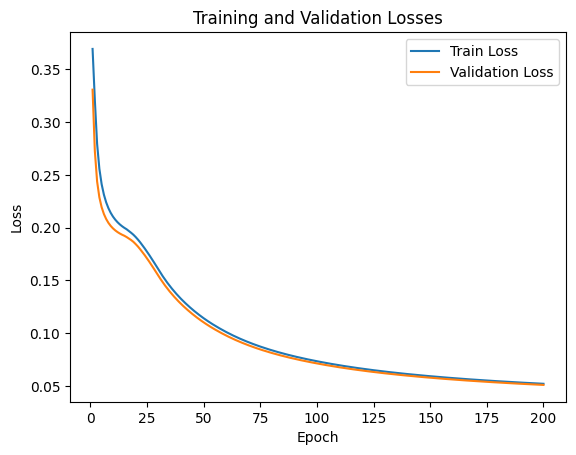

In [ ]:
train_res_recon_error = []
train_res_perplexity = []
val_res_recon_error = []
val_res_perplexity = []
train_losses = []
val_losses = []

for epoch in range(100):
    for i, (data, _) in enumerate(train_dl):
        data = data.float()
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity, hidden_quantized, encoding_index = model(data)
        recon_error = F.mse_loss(data_recon, data) / 1
        loss = recon_error + vq_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.2)

        optimizer.step()
        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())
        if epoch % 10 == 0 and epoch != 0:
            if (i + 1) % 200 == 0:
              print(f" Epoch {epoch} Train Loss: {loss} | Perplexity: {np.mean(train_res_perplexity[-100:])}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for val_data, _ in val_dl:
            val_data = val_data.float()
            val_vq_loss, val_data_recon, val_perplexity, _, _ = model(val_data)
            val_recon_error = F.mse_loss(val_data_recon, val_data) / 1
            val_loss = val_recon_error + val_vq_loss

            val_res_recon_error.append(val_recon_error.item())
            val_res_perplexity.append(val_perplexity.item())

    model.train()

    avg_train_loss = np.mean(train_res_recon_error)
    avg_val_loss = np.mean(val_res_recon_error)
    if epoch % 20 == 0 and i % 200 == 0:
            print(f"Epoch {epoch} | Validation Loss: {avg_val_loss:.4f} | Validation Perplexity: {np.mean(val_res_perplexity):.4f}")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

# Plot the losses
plt.plot(range(1, N_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, N_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.grid("True")
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

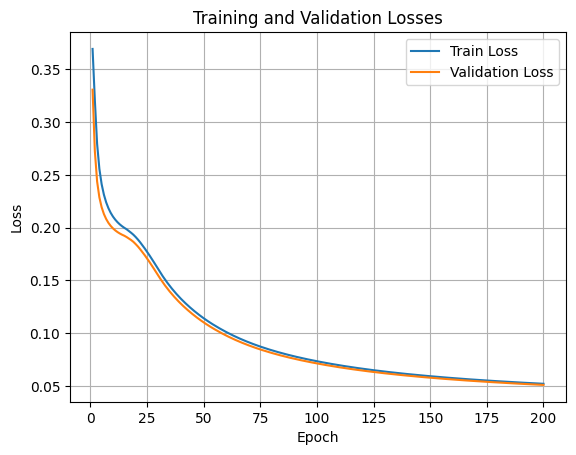

In [ ]:
plt.plot(range(1, N_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, N_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.grid("True")
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'vqvae_zdna_100.pth')

eval

In [ ]:
PATH = "vqvae_zdna_100.pth"

In [ ]:
model.load_state_dict(torch.load(PATH))
model.eval()

Model(
  (_encoder): Encoder(
    (_conv_1): Conv2d(1, 64, kernel_size=(4, 10), stride=(2, 2), padding=(1, 4))
    (_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (_pre_vq_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (_vq_vae): VectorQuantizerEMA(
    (_embedding): Embedding(512, 64)
  )
  (_decoder): Decoder(
    (_conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): Modul

In [ ]:
sequences = []
ss_type = []
chromosomes = []
fasta_files = [
    # '/content/drive/My Drive/data_for_gans/preprocessed_fastas/WuKou2016_filter-norm_to_512.fasta',
    # '/content/drive/My Drive/data_for_gans/preprocessed_fastas/zdna2016_filter-norm_to_512.fasta'
    # "/content/curax_filter-norm_to_500.fasta"
    '/content/drive/My Drive/data_for_gans/preprocessed_fastas/mmHDNA_filter-norm_to_500.fasta'
    # '/content/drive/My Drive/data_for_gans/preprocessed_fastas/_filter-norm_to_512.fasta'
]
for fasta_file in fasta_files:
  for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append(str(record.seq).upper())
    sequence = str(record.seq).upper()
    chrom_info = record.id.split('_')[0]
    chromosome = chrom_info if chrom_info.startswith("chr") else "chr" + chrom_info
    chromosomes.append(chromosome)

for seq in sequences:
    ss_type.append(types[2])
raw_dataset = pd.DataFrame({"chromosome": chromosomes, "raw_sequence": sequences, "type": ss_type, "label": 0})
raw_dataset.head()

,chromosome,raw_sequence,type,label
0,chr1:3024311-3024823,CTCTGCTAGCCAAACCCCAGCTGCCTCCTGGTTGTGCTGGCTGTGG...,H-DNA,0
1,chr1:3025192-3025704,GGGGTGGAGGAAACCAAGGCACAGAGAGATGGTGCCTCTGGGCAGC...,H-DNA,0
2,chr1:3034349-3034861,CTCCATGGGACCACAGACCCCAGGGCTCGCTGGTCTTGGGGAGAGG...,H-DNA,0
3,chr1:3034421-3034933,GAATGCAGGACAAAGGCTCCAGGTGGTGCCACAGATTCACCGGCTA...,H-DNA,0
4,chr1:3039922-3040434,ATTTATCAACCCCCAAGTGTGGCACCCGTGCAGAGGGGGGTGTGGG...,H-DNA,0


In [ ]:
raw_dataset.shape

(707657, 4)

In [ ]:
sequences = []
ss_type = []
chromosomes = []
fasta_files = [
    # '/content/drive/My Drive/data_for_gans/preprocessed_fastas/WuKou2016_filter-norm_to_512.fasta',
    # '/content/drive/My Drive/data_for_gans/preprocessed_fastas/zdna2016_filter-norm_to_512.fasta'
    # "/content/curax_filter-norm_to_500.fasta"
    '/content/drive/My Drive/data_for_gans/preprocessed_fastas/mmQuad_filter-norm_to_500.fasta'
    # '/content/drive/My Drive/data_for_gans/preprocessed_fastas/_filter-norm_to_512.fasta'
]
for fasta_file in fasta_files:
  for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append(str(record.seq).upper())
    sequence = str(record.seq).upper()
    chrom_info = record.id.split('_')[0]
    chromosome = chrom_info if chrom_info.startswith("chr") else "chr" + chrom_info
    chromosomes.append(chromosome)

for seq in sequences:
    ss_type.append(types[1])
g_dataset = pd.DataFrame({"chromosome": chromosomes, "raw_sequence": sequences, "type": ss_type, "label": 1})
g_dataset.head()

,chromosome,raw_sequence,type,label
0,chr1:3033783-3034295,GGCTGACCCAGGCTTACAGGCATTTTAAATACAAACATGGCAAGTG...,G-quad,1
1,chr1:3072334-3072846,AGTGAGAGACCAGCCTGGCCTCAGCTCAGGGACGCAGCTGATTTTG...,G-quad,1
2,chr1:3081414-3081926,TGGCCCCAGCTCCTTGGGAGATGCAGGTGGGAAGGCCGTCGCCACC...,G-quad,1
3,chr1:3086634-3087146,TCTTTTTTCCTCGCCGCTGGCCTGCTAAATGAATCTGAGGGCAGCT...,G-quad,1
4,chr1:3089751-3090263,TTGCTGCCCCCGGGGCTCAGGGAAGTGGTATATTAACCAAGGAATA...,G-quad,1


In [ ]:
h_dataset = g_dataset

In [ ]:
g_set = VAEDataset(h_dataset)
g_dl = DataLoader(g_set, batch_size=BATCH_SIZE)

In [ ]:
generated_sequences = []


for original_valid_data, _ in g_dl:

    original_valid_data = original_valid_data.float()

    vq_output = model._pre_vq_conv(model._encoder(original_valid_data))

    _, quantized_valid_data, _, _, _ = model._vq_vae(vq_output)

    reconstructed_valid_data = model._decoder(quantized_valid_data)

    ground_truth = torch.argmax(original_valid_data, dim=2)

    prediction = torch.argmax(reconstructed_valid_data, dim=2)
    generated_sequences.append(prediction)

In [ ]:
df_gen_sequences = []
# iterate over all sequences
for batch_prediction in generated_sequences:
    for prediction in batch_prediction:
        sample = []
        for nucleotide in prediction[0]:
            sample.append(NUCLEOTIDES_REVERSED[nucleotide.item()])

        df_gen_sequences.append("".join(sample))

In [ ]:
df_gen_sequences = pd.DataFrame({"raw_sequence": df_gen_sequences})

In [ ]:
df_gen_sequences.head()

,raw_sequence
0,GGGAAGGAAAACCCATCCTGCCCCTGAGAGCCTGAGAGGTGCATGT...
1,AGTTCTCACTGTGGTCTCAAACCGAGGTGCTCTGAGATGGGTTGAG...
2,AGGCCAGGAAGGCCAGTCACAGGAGCTCCGGGCCCCCCTCAGCCAG...
3,CAGAGACCCCCCGCTCCTGGCCTGAAGGGGAGAGGCTTCCTGAGAG...
4,GGGAAAGCAGCTCTCCCCGGAGCATTGCACAAAAAAAAAATCAGCA...


In [ ]:
df_gen_sequences.shape

(441946, 1)

In [ ]:
# bedG_df = pd.read_csv('/content/mmH-DNA.bed', sep='\t', comment='t', header=None)
bedH_df = pd.read_csv('/content/mmQuadruplex.bed', sep='\t', comment='t', header=None)

In [ ]:
bedG_df.columns = ["col1", "col2", "col3"]

In [ ]:
bedH_df.columns = ["col1", "col2", "col3", "col4", "col5", "col6"]

In [ ]:
bedH_df = bedH_df.drop(columns=["col4", "col5", "col6"])

In [ ]:
bedH_df

,col1,col2,col3
0,chr1,3019038,3019062
1,chr1,3034016,3034061
2,chr1,3072580,3072599
3,chr1,3081637,3081703
4,chr1,3086876,3086904
...,...,...,...
482828,chrY,2677285,2677359
482829,chrY,2848414,2848441
482830,chrY,2849426,2849459
482831,chrY,2853505,2853525


In [ ]:
un_bed_dataset = bedH_df


In [ ]:
un_bed_dataset

,col1,col2,col3
0,chr1,3019038,3019062
1,chr1,3034016,3034061
2,chr1,3072580,3072599
3,chr1,3081637,3081703
4,chr1,3086876,3086904
...,...,...,...
482828,chrY,2677285,2677359
482829,chrY,2848414,2848441
482830,chrY,2849426,2849459
482831,chrY,2853505,2853525


In [ ]:
generated_sequences = []

for original_valid_data, _ in g_dl:
    original_valid_data = original_valid_data.float()

    vq_output = model._pre_vq_conv(model._encoder(original_valid_data))
    _, quantized_valid_data, _, _, _ = model._vq_vae(vq_output)

    reconstructed_valid_data = model._decoder(quantized_valid_data)

    ground_truth = torch.argmax(original_valid_data, dim=2)

    prediction = torch.argmax(reconstructed_valid_data, dim=2)
    generated_sequences.append(prediction)

In [ ]:
un_bed_dataset.shape

(1211188, 3)

In [ ]:
un_bed_dataset.columns = ['chrom', 'chromStart', 'chromEnd']

In [ ]:
df_gen_sequences = []
ss_type = []
# iterate over all sequences
for batch_prediction in generated_sequences:
    for prediction in batch_prediction:
        sample = []
        for nucleotide in prediction[0]:
            sample.append(NUCLEOTIDES_REVERSED[nucleotide.item()])

        df_gen_sequences.append("".join(sample))
for seq in df_gen_sequences:
    ss_type.append(types[2])
df_gen_sequences = pd.DataFrame({"chrom": un_bed_dataset[:len(df_gen_sequences)].chrom, "raw_sequence": df_gen_sequences, "type": ss_type})

In [ ]:
df_gen_sequences

,chrom,raw_sequence,type
0,chr1,GGGAAGGAAAACCCATCCTGCCCCTGAGAGCCTGAGAGGTGCATGT...,H-DNA
1,chr1,AGTTCTCACTGTGGTCTCAAACCGAGGTGCTCTGAGATGGGTTGAG...,H-DNA
2,chr1,AGGCCAGGAAGGCCAGTCACAGGAGCTCCGGGCCCCCCTCAGCCAG...,H-DNA
3,chr1,CAGAGACCCCCCGCTCCTGGCCTGAAGGGGAGAGGCTTCCTGAGAG...,H-DNA
4,chr1,GGGAAAGCAGCTCTCCCCGGAGCATTGCACAAAAAAAAAATCAGCA...,H-DNA
...,...,...,...
441941,chr19,CCATTTGGAGTGTGTGGGTGTCTGAGTCTCTTTGGAGGTCTCTAAG...,H-DNA
441942,chr19,TGACACTTTGTACCCATTCCCTCCTTCACATGTGTGTCACACTGGA...,H-DNA
441943,chr19,AGTGATTTGTGAGTAAAAAAGACAAAGTTTGAAAGCACTGATTTAT...,H-DNA
441944,chr19,GTTTTGGAGTCGGAGGCTTGCTCTGCTGCCCAGGCTGCAGTGCAAA...,H-DNA


In [ ]:
df_gen_sequences_to_fasta = df_gen_sequences.drop(columns=["type"])

In [ ]:
df_gen_sequences_to_fasta

,chrom,raw_sequence
0,chr1,GGGAAGGAAAACCCATCCTGCCCCTGAGAGCCTGAGAGGTGCATGT...
1,chr1,AGTTCTCACTGTGGTCTCAAACCGAGGTGCTCTGAGATGGGTTGAG...
2,chr1,AGGCCAGGAAGGCCAGTCACAGGAGCTCCGGGCCCCCCTCAGCCAG...
3,chr1,CAGAGACCCCCCGCTCCTGGCCTGAAGGGGAGAGGCTTCCTGAGAG...
4,chr1,GGGAAAGCAGCTCTCCCCGGAGCATTGCACAAAAAAAAAATCAGCA...
...,...,...
441941,chr19,CCATTTGGAGTGTGTGGGTGTCTGAGTCTCTTTGGAGGTCTCTAAG...
441942,chr19,TGACACTTTGTACCCATTCCCTCCTTCACATGTGTGTCACACTGGA...
441943,chr19,AGTGATTTGTGAGTAAAAAAGACAAAGTTTGAAAGCACTGATTTAT...
441944,chr19,GTTTTGGAGTCGGAGGCTTGCTCTGCTGCCCAGGCTGCAGTGCAAA...


In [ ]:
fasta_lines = []

for index, row in df_gen_sequences_to_fasta.iterrows():
    chrom = row['chrom']
    sequence = row['raw_sequence']

    fasta_lines.append(f'>{chrom}\n{sequence}\n')

fasta_file_path = '/content/mmQ_vqvae.fasta'
with open(fasta_file_path, 'w') as fasta_file:
    fasta_file.writelines(fasta_lines)

In [ ]:
initial_dataset = raw_dataset
generated_dataset = df_gen_sequences

initial_sequences = initial_dataset.raw_sequence.tolist()
generated_sequences = generated_dataset.raw_sequence.tolist()

target_length = 100

novelty_result_optimized_one_hot = calculate_novelty_optimized_one_hot(generated_sequences, initial_sequences, target_length)

print(f"Original Novelty (One-Hot): {novelty_result_optimized_one_hot}")

Original Novelty (One-Hot): 9.969300182856028


In [ ]:
dataset = generated_dataset


sequences = dataset.raw_sequence.tolist()

target_length = 100

diversity_result_optimized_one_hot = calculate_diversity_optimized_one_hot(sequences, target_length)

print(f"Original Diversity (One-Hot): {diversity_result_optimized_one_hot}")
